In [1]:
# system tools
import warnings
import json
import sys
import string
import ast
import logging

# data cleaning + analysis tools
import pandas as pd
import datetime as dt
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

#nlp tools
import lda #Latent Dirichlet Allocation (create topics)
import gensim
import spacy
from gensim import corpora, models #for constructing document term matrix
#from stop_words import get_stop_words
from gensim.models import Phrases
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

#set notebook preferences
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


##  Import data frame from cleaning/preprocessing

In [2]:
data = pd.read_csv('data.csv')
data['final_mash'] = data['final_mash'].apply(lambda x:  ast.literal_eval(x))
data['mash'] = data['mash'].apply(lambda x:  ast.literal_eval(x))
data['common_bigrams'] = data['common_bigrams'].apply(lambda x:  ast.literal_eval(x))
data['token'] = data['token'].apply(lambda x:  ast.literal_eval(x))
data['lemma'] = data['lemma'].apply(lambda x:  ast.literal_eval(x))

In [209]:
data.head()

,index,Summary,city,month_year,token_sp,pn,sum_ed,token,lemma,mash,mash_len,bigrams,common_bigrams,final_mash,ave
0,0,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,Arlington,2018-06,We are working with an engineering firm on an upcoming project They have asked us to gather maps for this project Would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have Something just showing the route of the water lines would do\n\nth ST NE to nd Ave NE Arlington Cascade Surveying Engineering \n\nI have attached the scope for your convenience Please let me know if you have questions,"[ave, ne, arlington, cascade, surveying, engineering]",we are working with an engineering firm on an upcoming project they have asked us to gather maps for this project would you be able to assist me in gathering mapsrecords as builds for any underground water facilities you may have something just showing the route of the water lines would do\n\nth st ne to nd ave ne arlington cascade surveying engineering \n\ni have attached the scope for your convenience please let me know if you have questions,"[we, are, working, with, an, engineering, firm, on, an, upcoming, project, they, have, asked, us, to, gather, maps, for, this, project, would, you, be, able, to, assist, me, in, gathering, mapsrecords, as, builds, for, any, underground, water, facilities, you, may, have, something, just, showing, the, route, of, the, water, lines, would, do, th, st, to, nd, cascade, surveying, engineering, i, have, attached, the, scope, for, your, convenience, please, let, me, know, if, you, have, questions]","[(we, PRP), (are, VBP), (working, VBG), (with, IN), (an, DT), (engineering, NN), (firm, NN), (on, IN), (an, DT), (upcoming, JJ), (project, NN), (they, PRP), (have, VBP), (asked, VBN), (us, PRP), (to, TO), (gather, VB), (maps, NNS), (for, IN), (this, DT), (project, NN), (would, MD), (you, PRP), (be, VB), (able, JJ), (to, TO), (assist, VB), (me, PRP), (in, IN), (gathering, VBG), (mapsrecords, NNS), (as, IN), (builds, NNS), (for, IN), (any, DT), (underground, JJ), (water, NN), (facilities, NNS), (you, PRP), (may, MD), (have, VB), (something, NN), (just, RB), (showing, VBG), (the, DT), (route, NN), (of, IN), (the, DT), (water, NN), (lines, NNS), (would, MD), (do, VB), (th, VB), (st, VB), (to, TO), (nd, VB), (cascade, JJ), (surveying, VBG), (engineering, NN), (i, NN), (have, VBP), (attached, VBN), (the, DT), (scope, NN), (for, IN), (your, PRP$), (convenience, NN), (please, NN), (let, VB), (me, PRP), (know, VB), (if, IN), (you, PRP), (have, VBP), (questions, NNS)]","[work, engineering, firm, upcoming, project, ask, u, gather, map, project, would, able, assist, gather, mapsrecords, build, underground, water, facility, may, something, show, route, water, line, would, th, st, nd, cascade, survey, engineering, attach, scope, convenience, please, let, know, question]",39,"[work_engineering, engineering_firm, firm_upcoming, upcoming_project, project_ask, ask_u, u_gather, gather_map, map_project, project_would, would_able, able_assist, assist_gather, gather_mapsrecords, mapsrecords_build, build_underground, underground_water, water_facility, facility_may, may_something, something_show, show_route, route_water, water_line, line_would, would_th, th_st, st_nd, nd_cascade, cascade_survey, survey_engineering, engineering_attach, attach_scope, scope_convenience, convenience_please, please_let, let_know, know_question]",[],"[work, engineering, firm, upcoming, project, gather, map, project, assist, gather, mapsrecords, build, underground, water, facil

In [310]:
# distribution of final mash lengths as baseline

data.mash_len.describe()

count    89324.000000
mean        12.826474
std         24.095661
min          1.000000
25%          2.000000
50%          6.000000
75%         15.000000
max       2472.000000
Name: mash_len, dtype: float64

In [4]:
# produce dictionary with frequency of all words in final mash to use for thresholds

fm_list = [y for x in list(data['final_mash']) for y in x]
counts = Counter(fm_list)

In [23]:
counts.most_common(10)

[('property', 13058),
 ('number', 11451),
 ('incident', 10264),
 ('police', 9587),
 ('permit', 9376),
 ('accident', 9038),
 ('address', 8436),
 ('department', 8347),
 ('location', 7985),
 ('email', 7463)]

In [22]:
# calculate distribution of word count 
count_df = pd.Series(counts, name = 'count') 
count_df.index.name = 'word'
count_df = count_df.reset_index()
count_df['count'].describe()

count    40196.000000
mean        29.150463
std        251.991662
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      13058.000000
Name: count, dtype: float64

### Functions to analyze model performance

In [ ]:
def highest_topic(fp):
    df = pd.read_csv(fp)
    df['topic_comp'] =  df['topic_comp'].apply(lambda x:  ast.literal_eval(x))
    df['comp_len'] = df['topic_comp'].apply(len)
    df = df[df['comp_len'] > 0]
    df['top_topic'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[0])
    df['top_topic_comp'] = df['topic_comp'].apply(lambda x: max(x, key=lambda item:item[1])[1])
    
    return df

def topics_to_csv(df, num_topics):
    for topic in range(0, num_topics):
        subset = df[df['top_topic'] == topic]
        file_name = 'topics/{}_PRR_topic_{}.csv'.format(num_topics, topic)
        subset.to_csv(file_name)

## First, we determine the optimal number of passes and topics for analysis

To identify a baseline number of topics to start from, we look at the 10 cities that publish some sort of categorization with the PRR. In most cases, this is the department that the PRR was routed to for response. Though a department is not necessarily analagous to a topic, this can provide a useful starting point for our analysis.

In [27]:
city_list = ['Bainbridge', 'LasCruces', 'FortCollins', 'Mercer', 'Nola', 'Oakland', 'PaloAlto', 'Redmond', 
             'SanFrancisco', 'Vallejo']
total = 0
for city in city_list:
    filepath = '/Users/alenastern/Google Drive File Stream/My Drive/Alena_Project/PR_Data/{}.csv'.format(city)
    df = pd.read_csv(filepath)
    df = df.dropna(subset=['Dept'])
    df['dpt_list'] = df['Dept'].str.split(';')
    dept_list = [y for x in list(df['dpt_list']) for y in x]
    dpt_set = set(dept_list)
    print(len(dpt_set))
    total += len(dpt_set)

print(total/len(city_list))
    

10
40
37
17
115
73
15
227
10
25
56.9


We see a significant range in the number of topics cities use when they categorize their own data by department, but the average is 57 departments. We'll therefore use 60 as our baseline number of topics.

In [3]:
# Create dictionary and corpus from cleaned data for analysis

texts = list(data['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

We test the combination of several different numbers of topics (centering on 60) and passes to first identify the optimal number of passes. The ideal number of passes is the minimum number of passes at which the nearly all of the documents converge at the end of the number of passes. This strikes the proper balance between model quality and efficiency (as the higher the number of passes, the more time each model takes to run)


In [ ]:
num_topics_list = [40, 60, 80]
num_passes_list = [20, 40, 60]
for n in num_topics_list:
    for p in num_passes_list:
   
        # Set up log to external log file
        log_file = 'logs/lda_model_{}_{}.log'.format(n, p)
        logging.basicConfig(filename= log_file, format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


        lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                             passes = p, random_state=7, eval_every = 5)

        model_name = "lda_{}_{}_model".format(n, p)
        lda.save(model_name)
        corpus_lda = lda[corpus]
        corpus_lda_list = list(corpus_lda)
        topics = data.copy()
        topics = topics.assign(topic_comp = corpus_lda_list)
        file_name = "topics/lda_{}_{}_topics.csv".format(n, p)
        topics.to_csv(file_name)

We see that the 20 pass option has nearly all of the documents in each chunk converge, while the 40 pass option has all of the documents converge. Therefore we use 30 passes to make sure the documents will converge but avoiding excess passes to increase the time of our testing.

In [ ]:
# We test different numbers of topics and 30 passes to identify the number of topics that yields the best results:
 
num_topics_list = [20, 30, 40, 50, 55, 60, 65, 70, 80]
for n in num_topics_list:
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                         passes = 30, random_state=7)
    
    model_name = "lda_{}_30_model".format(n)
    lda.save(model_name)
    corpus_lda = lda[corpus]
    corpus_lda_list = list(corpus_lda)
    topics = data.copy()
    topics = topics.assign(topic_comp = corpus_lda_list)
    file_name = "topics/lda_{}_30_topics.csv".format(n)
    topics.to_csv(file_name)
    

In [5]:
sixty_model = gensim.models.ldamodel.LdaModel.load('lda_60_30_model')
sixty_model.show_topics(num_topics=60, formatted=False)

[(0,
  [('letter', 0.09737549),
   ('communication', 0.093455285),
   ('correspondence', 0.08368736),
   ('email', 0.069632255),
   ('limited', 0.060233984),
   ('documentation', 0.058903128),
   ('form', 0.048268627),
   ('period', 0.033304118),
   ('official', 0.02801319),
   ('electronic', 0.026774943)]),
 (1,
  [('subcontractor', 0.1035794),
   ('cd', 0.067948595),
   ('update', 0.056225896),
   ('avondale', 0.05379066),
   ('close', 0.050888896),
   ('animal', 0.037690345),
   ('picture', 0.036542214),
   ('exclude', 0.029632203),
   ('geotechnical', 0.023900187),
   ('village', 0.022369672)]),
 (2,
  [('cost', 0.0360035),
   ('section', 0.03540753),
   ('bid', 0.02677816),
   ('pay', 0.02605406),
   ('amount', 0.022230323),
   ('following', 0.020322695),
   ('act', 0.019396419),
   ('government', 0.019075986),
   ('time', 0.01785439),
   ('require', 0.016672151)]),
 (3,
  [('notice', 0.16474165),
   ('body', 0.08646261),
   ('cam', 0.05418779),
   ('sec', 0.050940704),
   ('turn'

Looking at the results of our models, we find that the 60 topic model produces the most coherent results. We therefore use 60 topics for the rest of our model training. However, we still see some issues with the topics when we look at the PRRs which were grouped together into the same topic. Namely, we see that a considerable number PRRs that contain only a rare proper name (that was not included in our dictionary of proper names) were included in the training set, weakening our model results. We test a number of additional screening criteria for PRRs to include in our training set to see if they improve performance. Overall, we are looking for the criteria that provides the best model results while including the largest number of observations in the training set.

## LDA Model Tests

### 1) Remove words at or below certain count

### 1a) Count = 1


In [5]:
data1 = data.copy()
data1['mash'] = data1['mash'].apply(lambda x: [i for i in x if counts[i] > 1])
data1['final_mash'] = data1['mash'] + data1['common_bigrams']

In [6]:
data1['mash_len'] = data1['final_mash'].apply(len)
data1 = data1[data1['mash_len'] != 0]
data1.mash_len.describe()

count    88252.000000
mean        13.019467
std         24.145953
min          1.000000
25%          3.000000
50%          6.000000
75%         15.000000
max       2435.000000
Name: mash_len, dtype: float64

### 1b) count = 10

In [9]:
data10 = data.copy()
data10['mash'] = data10['mash'].apply(lambda x: [i for i in x if counts[i] > 10])
data10['final_mash'] = data10['mash'] + data10['common_bigrams']

In [10]:
data10['mash_len'] = data10['final_mash'].apply(len)
data10 = data10[data10['mash_len'] != 0]
data10.mash_len.describe()

count    87321.000000
mean        12.644415
std         23.089707
min          1.000000
25%          2.000000
50%          6.000000
75%         15.000000
max       2205.000000
Name: mash_len, dtype: float64

### 2) Drop cities with low (less than 4) average count - Greensboro, Dayton, OKC

Three of the cities in our sample (Greensboro, Dayton, Oklahoma City) have average mash lengths of less than 4 words. We are concerned that these cities may be reducing the effectiveness of the model, so we test whether our model performs better if we drop these cities.

In [11]:
data_lg_cities = data.copy()

In [12]:
data_lg_cities = data_lg_cities[(data['city'] != 'Greensboro') & 
                               (data['city'] != 'Dayton') & (data['city'] != 'OKC')]
data_lg_cities['mash_len'] = data_lg_cities['final_mash'].apply(len)
data_lg_cities.mash_len.describe()

count    84326.000000
mean        13.750706
std         25.034585
min          1.000000
25%          3.000000
50%          7.000000
75%         16.000000
max       2512.000000
Name: mash_len, dtype: float64

## 3) Remove observations with small number of words in final mash 

### 3a) Mash length greater than 2

In [91]:
data_3a = data.copy()
data_3a = data_3a[data_3a['mash_len'] > 2]

#### 3a.1) Model 1a + Mash length greater than 2 

In [116]:
data_3a1 = data1.copy()
data_3a1 = data_3a1[data_3a1['mash_len'] > 2]

#### 3a.2) Model 1b + Mash length greater than 2

In [117]:
data_3a2 = data10.copy()
data_3a2 = data_3a2[data_3a2['mash_len'] > 2]

#### 3a.3) Model 2 + Mash length greater than 2

In [96]:
data_3a3 = data_lg_cities.copy()
data_3a3 = data_3a3[data_3a3['mash_len'] > 2]

### 3b) Mash length greater than 3

In [99]:
data_3b = data.copy()
data_3b = data_3b[data_3b['mash_len'] > 3]

#### 3b.1) Model 1a + Mash length greater than 3

In [118]:
data_3b1 = data1.copy()
data_3b1 = data_3b1[data_3b1['mash_len'] > 3]

#### 3b.2) Model 1b + Mash length greater than 3

In [119]:
data_3b2 = data10.copy()
data_3b2 = data_3b2[data_3b2['mash_len'] > 3]

#### 3b.3) Model 2 + Mash length greater than 3

In [104]:
data_3b3 = data_lg_cities.copy()
data_3b3 = data_3b3[data_3b3['mash_len'] > 3]

## 4) Remove observations with both a short length and a low total word frequency

We notice that a significant number of PRRs in our sample have a 1 or 2-word final mash, but those words are very descriptive (eg. "building_permit"). We want to preserve these PRRs that have a short but meaningful final mash, while still excluding those PRRs that have a short but unusable final mash (such as a rare proper name that was not removed because it was not in our dictionary). We apply this hybrid approach to remove observations that have a short mash length with relatively rare words. 

In [13]:
data_c = data.copy()
data_c['count_total'] = data_c['final_mash'].apply(lambda x: sum(counts[i] for i in x))
data_c.count_total.describe()

count    8.914500e+04
mean     2.901487e+04
std      4.119699e+04
min      1.000000e+00
25%      5.490000e+03
50%      1.604800e+04
75%      3.546400e+04
max      1.763482e+06
Name: count_total, dtype: float64

#### 4a) # Total count > 1000 or mash length > 3

In [14]:
data_c1000_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 1000)]
data_c1000_3.mash_len.describe()

count    82954.000000
mean        14.020988
std         25.162419
min          1.000000
25%          3.000000
50%          7.000000
75%         16.000000
max       2512.000000
Name: mash_len, dtype: float64

#### 4b) Total count > 2000 or mash length > 3

In [15]:
data_c2000_3 = data_c[(data_c['mash_len'] > 3) | (data_c['count_total'] > 2000)]
data_c2000_3.mash_len.describe()

count    79909.000000
mean        14.491472
std         25.519064
min          1.000000
25%          3.000000
50%          8.000000
75%         17.000000
max       2512.000000
Name: mash_len, dtype: float64

## 5) Remove observations with a low average mash length

We also try a more restrictive version of model 4a above by also taking into account the average mash length. This will remove PRRs that have a long mash length of all very rare words (such as a list of rare names).

In [22]:
data_avg = data_c1000_3.copy()
data_avg['avg_count'] = data_avg['count_total']/ data_avg['mash_len']
data_avg.avg_count.describe()

count    82954.000000
mean      2845.963458
std       1846.929409
min          1.000000
25%       1482.042411
50%       2445.000000
75%       3693.034722
max      13058.000000
Name: avg_count, dtype: float64

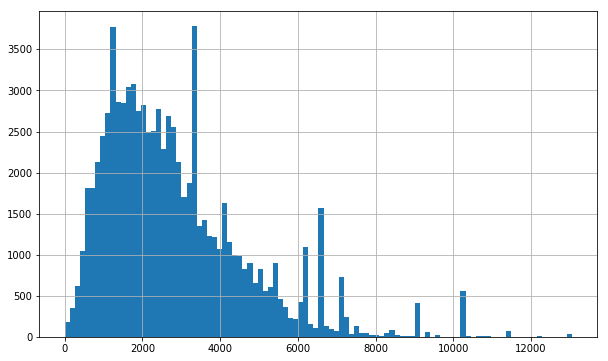

In [18]:
# plot the distribution of average count to identify a cutoff
data_avg.avg_count.hist(bins = 100)
plt.show()

In [23]:
data_avg = data_avg[data_avg['avg_count'] > 600]
data_avg.mash_len.describe()

count    79676.000000
mean        14.246912
std         25.371389
min          1.000000
25%          3.000000
50%          7.000000
75%         17.000000
max       2512.000000
Name: mash_len, dtype: float64

## Run all LDA models

In [ ]:
# Model 1a - words count > 1

texts = list(data1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data1"
lda_data1.save(model_name)
corpus_lda = lda_data1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data1.csv"
topics.to_csv(file_name)

# Model 1b - words count > 10

texts = list(data10['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data10 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data10"
lda_data10.save(model_name)
corpus_lda = lda_data10[corpus]
corpus_lda_list = list(corpus_lda)
topics = data10.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data10.csv"
topics.to_csv(file_name)

In [ ]:
# Model 2

texts = list(data_lg_cities['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_lg_cities = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_lg_cities"
lda_data_lg_cities.save(model_name)
corpus_lda = lda_data_lg_cities[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_lg_cities.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_lg_cities.csv"
topics.to_csv(file_name)


# Model 3a

texts = list(data_3a['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_3a = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_3a"
lda_data_3a.save(model_name)
corpus_lda = lda_data_4a[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_3a.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_3a.csv"
topics.to_csv(file_name)

# Model 3a1

texts = list(data_3a1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_3a1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_3a1"
lda_data_3a1.save(model_name)
corpus_lda = lda_data_3a1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_3a1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_3a1.csv"
topics.to_csv(file_name)

# Model 3a2

texts = list(data_3a2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_3a2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_3a2"
lda_data_3a2.save(model_name)
corpus_lda = lda_data_3a2[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_3a2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_3a2.csv"
topics.to_csv(file_name)

# Model 3a3

texts = list(data_3a3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_3a3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_3a3"
lda_data_3a3.save(model_name)
corpus_lda = lda_data_3a3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_3a3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_3a3.csv"
topics.to_csv(file_name)

# Model 3b

texts = list(data_3b['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_3b = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_3b"
lda_data_3b.save(model_name)
corpus_lda = lda_data_3b[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_3b.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_3b.csv"
topics.to_csv(file_name)

# Model 3b1

texts = list(data_3b1['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_3b1 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_3b1"
lda_data_3b1.save(model_name)
corpus_lda = lda_data_3b1[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_3b1.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_3b1.csv"
topics.to_csv(file_name)

# Model 3b2

texts = list(data_3b2['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_3b2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_3b2"
lda_data_3b2.save(model_name)
corpus_lda = lda_data_3b2[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_3b2.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_3b2.csv"
topics.to_csv(file_name)

# Model 3b3

texts = list(data_3b3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_data_3b3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_3b3"
lda_data_3b3.save(model_name)
corpus_lda = lda_data_3b3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_3b3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_3b3.csv"
topics.to_csv(file_name)

In [29]:
# Model 4a

texts = list(data_c1000_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


lda_data_c1000_3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_c1000_3_60"
lda_data_c1000_3.save(model_name)
corpus_lda = lda_data_c1000_3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c1000_3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c1000_3_60.csv".format(n)
topics.to_csv(file_name)


# Model 4b

texts = list(data_c2000_3['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


lda_data_c2000_3 = gensim.models.ldamodel.LdaModel(corpus, num_topics=60, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_c2000_3_60"
lda_data_c2000_3.save(model_name)
corpus_lda = lda_data_c2000_3[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_c2000_3.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_c2000_3_60.csv".format(n)
topics.to_csv(file_name)

In [ ]:
# Model 5

texts = list(data_avg['final_mash'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


lda_data_avg = gensim.models.ldamodel.LdaModel(corpus, num_topics=n, id2word = dictionary, 
                                         passes = 30, random_state=7)
model_name = "lda_data_avg"
lda_data_avg.save(model_name)
corpus_lda = lda_data_avg[corpus]
corpus_lda_list = list(corpus_lda)
topics = data_avg.copy()
topics = topics.assign(topic_comp = corpus_lda_list)
file_name = "topics/lda_data_avg.csv"
topics.to_csv(file_name)

When we evaluate the results of all of our models, we find that model 4b (mash length > 3 or total count > 2000) and model 5 (mash length > 3 or total count > 1000 and average count greater than 600) are our best performing models, with similar quality output. Because model 4b includes more PRRs in the training set, **we use model 4b as our final model for analysis.**

We produce csv files for the set of PRRs that have belong to each of the 60 topics generated by the model (as determined by which topic has the highest topic composition score for a given PRR) and can see the final topics below. 

In [ ]:
df = highest_topic('topics/lda_data_c2000_3_60.csv')
topics_to_csv(df, 60)

In [24]:
lda_data_c2000_3_60 = gensim.models.ldamodel.LdaModel.load('lda_data_c2000_3_60')
lda_data_c2000_3_60.show_topics(num_topics=60, formatted=False)

[(0,
  [('complaint', 0.1985935),
   ('log', 0.14190955),
   ('phone', 0.08581352),
   ('search', 0.083066285),
   ('warrant', 0.03568498),
   ('estate', 0.032001145),
   ('involved', 0.026251603),
   ('quality', 0.02599625),
   ('real', 0.025753625),
   ('ensure', 0.019929796)]),
 (1,
  [('associate', 0.14829391),
   ('client', 0.11122169),
   ('photograph', 0.10852045),
   ('office', 0.08708323),
   ('follow', 0.061714146),
   ('emergency', 0.042823374),
   ('transfer', 0.033178225),
   ('color', 0.024401158),
   ('restaurant', 0.02243146),
   ('time', 0.018097397)]),
 (2,
  [('name', 0.15037733),
   ('victim', 0.084349126),
   ('crime', 0.082644366),
   ('officer', 0.07667519),
   ('domestic', 0.041578013),
   ('violence', 0.03346935),
   ('injury', 0.030954132),
   ('capitol', 0.030555379),
   ('location', 0.027925178),
   ('type', 0.021750417)]),
 (3,
  [('permit', 0.2758547),
   ('issue', 0.11701758),
   ('building', 0.07663683),
   ('build', 0.06414055),
   ('building_permit', 0